# Training an augmented Boltzmann Generator for Alanine Dipeptide

This notebook introduces basic concepts behind `bgtorch`. 

It shows how to build an train a Boltzmann generator for a small peptide. The most important aspects it will cover are

- retrieval of molecular training data
- defining a internal coordinate transform
- defining normalizing flow classes
- combining different normalizing flows
- training a Boltzmann generator via NLL and KLL

The main purpose of this tutorial is to introduce the implementation, so that the network design is rather simple for educational purposes. In the conlusions, we will discuss some aspects of the generator that are not ideal and outline improvements.

## Some Preliminaries

We instruct jupyter to reload any imports automatically and define the device and datatype, on which we want to perform the computations.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)



## Load the Data and the Molecular System

Molecular trajectories and their corresponding potential energy functions are available from the `openmmsystems` repository.

In [4]:
from openmmsystems.datasets import Ala2TSF300

dataset = Ala2TSF300(download=True, read=True)
system = dataset.system
coordinates = dataset.coordinates
temperature = dataset.temperature
dim = dataset.dim

  1%|          | 1933312/239629978 [00:00<00:12, 19329221.26it/s]

239632384it [00:02, 112324171.80it/s]                               


Extracting /srv/public/kraemea88/coding/bgtorch/notebooks/Ala2TSF300.tgz to /srv/public/kraemea88/coding/bgtorch/notebooks
Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


The energy model is a `bgtorch.Energy` that wraps around OpenMM. The `n_workers` argument determines the number of openmm contexts that are used for energy evaluations. In notebooks, we set `n_workers = 1` to avoid hickups. In production, we can omit this argument so that `n_workers` is automatically set to the number of CPU cores.

In [5]:
target_energy = dataset.get_energy_model(n_workers=1)

### Visualize Data: Ramachandran Plot for the Backbone Angles

In [6]:
from openmmsystems.systems.ala2 import AlanineDipeptideImplicit

phi, psi = system.compute_phi_psi(dataset.trajectory)

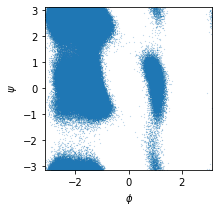

In [7]:
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(phi, psi, s=0.01)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel("$\phi$")
_ = ax.set_ylabel("$\psi$")

## Split Data and Randomly Permute Samples

In [8]:
n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)

all_data = coordinates.reshape(-1, dataset.dim)
training_data = torch.tensor(all_data[permutation]).to(ctx)
test_data = torch.tensor(all_data[permutation + n_train]).to(ctx)

## Define the Internal Coordinate Transform

Rather than generating all-Cartesian coordinates, we use a mixed internal coordinate transform.
The five central alanine atoms will serve as a Cartesian "anchor", from which all other atoms are placed with respect to internal coordinates (IC) defined through a z-matrix. We have deposited a valid `z_matrix` and the corresponding `rigid_block` in the `dataset.system` from `openmmsystems`.

In [9]:
# throw away 6 degrees of freedom (rotation and translation)
dim_cartesian = len(system.rigid_block) * 3 - 6
dim_bonds = len(system.z_matrix)
dim_angles = dim_bonds
dim_torsions = dim_bonds

In [10]:
from bgtorch import nn

coordinate_transform = nn.MixedCoordinateTransformation(
    data=training_data, 
    z_matrix=system.z_matrix,
    fixed_atoms=system.rigid_block,
    keepdims=dim_cartesian, 
    normalize_angles=True,
).to(ctx)

For demonstration, we transform the first 3 samples from the training data set into internal coordinates as follows:

In [11]:
bonds, angles, torsions, cartesian, dlogp = coordinate_transform.forward(training_data[:3])

print(bonds.shape, angles.shape, torsions.shape, cartesian.shape, dlogp.shape)

torch.Size([3, 17]) torch.Size([3, 17]) torch.Size([3, 17]) torch.Size([3, 9]) torch.Size([3, 1])


## Prior Distribution

The next step is to define a prior distribution that we can easily sample from. The normalizing flow will be trained to transform such latent samples into molecular coordinates. Here, we just take a normal distribution, which is a rather naive choice for reasons that will be discussed in other notebooks.

In [12]:
from bgtorch import NormalDistribution

dim_ics = dim_bonds + dim_angles + dim_torsions + dim_cartesian
mean = torch.zeros(dim_ics).to(ctx) # passing this explicitly to create samples of the right device and dtype
prior = NormalDistribution(dim_ics, mean=mean)

## Normalizing Flow

Next, we set up the normalizing flow by stacking together different neural networks. For now, we will do this in a rather naive way, not distinguishing between bonds, angles, and torsions. Therefore, we will first define a flow that splits the output from the prior into the different IC terms.

### Split Layer

In [13]:
# TODO: this has to go into the repo

class SplitFlow(nn.Flow):
    def __init__(self, *sizes):
        super().__init__()
        self._sizes = sizes
    
    def _forward(self, x, **kwargs):
        *y, = torch.split(x, self._sizes, dim=-1)
        dlogp = torch.zeros_like(x[...,[0]])
        return (*y, dlogp)
    
    def _inverse(self, *xs, **kwargs):
        y = torch.cat(xs, dim=-1)
        dlogp = torch.zeros_like(xs[0][...,[0]])
        return (y, dlogp)

In [14]:
split_into_ics_flow = SplitFlow(dim_bonds, dim_angles, dim_torsions, dim_cartesian)

In [15]:
# test
_ics = split_into_ics_flow(prior.sample(3))[:-1]
coordinate_transform.forward(*_ics, inverse=True)[0].shape

torch.Size([3, 66])

### Coupling Layers

Next, we will set up so-called RealNVP coupling layers, which split the input into two channels and then learn affine transformations of channel 1 conditioned on channel 2. Here we will do the split on a random subset of indices.

In [16]:
class RandomPermuteFlow(nn.Flow):
    
    def __init__(self, dim):
        super().__init__()
        self.permutation = torch.randperm(dim)
        self.inverse_permutation = torch.argsort(self.permutation)
        
    def _forward(self, x, **kwargs):
        dlogp = torch.zeros_like(x[...,[0]])
        return x[..., self.permutation], dlogp
    
    def _inverse(self, x, **kwargs):
        dlogp = torch.zeros_like(x[...,[0]])
        return x[..., self.inverse_permutation], dlogp

In [17]:
class RealNVP(nn.SequentialFlow):
    
    def __init__(self, dim, hidden=[128, 128, 128]):
        self.dim = dim
        self.hidden = hidden
        super().__init__(self._create_layers())
    
    def _create_layers(self):
        dim_channel1 =  self.dim//2
        dim_channel2 = self.dim - dim_channel1
        random_permute = RandomPermuteFlow(self.dim)
        split_into_2 = SplitFlow(dim_channel1, dim_channel2)
        
        # --- split in 2 channels
        layers = []
        layers.append(random_permute)
        layers.append(split_into_2)
        # --- transform
        layers.append(self._create_coupling(dim_channel1, dim_channel2))
        layers.append(nn.SwapFlow())
        layers.append(self._create_coupling(dim_channel2, dim_channel1))
        # ---  merge             
        layers.append(nn.InverseFlow(split_into_2))
        layers.append(nn.InverseFlow(random_permute))
        return layers
        
    def _create_dense(self, dim1, dim2):
        return nn.DenseNet(
            [dim1, *self.hidden, dim2],
            activation=torch.nn.ReLU()
        )
    
    def _create_coupling(self, dim1, dim2):
        return nn.CouplingFlow(nn.AffineTransformer(
            shift_transformation = self._create_dense(dim1, dim2),
            scale_transformation = self._create_dense(dim1, dim2)
        ))
    

In [18]:
RealNVP(dim_ics).to(ctx).forward(prior.sample(3))[0].shape

torch.Size([3, 60])

### Boltzmann Generator

Finally, we define the Boltzmann generator.
It will sample molecular conformations by 

1. sampling in latent space from the normal prior distribution
2. transforming the samples into a more complication distribution through a number of RealNVP blocks (the parameters of these blocks will be subject to optimization)
3. splitting the 60-dimensional output into blocks that define the internal coordinates
4. transforming the internal coordinates into Cartesian coordinates through the inverse IC transform

In [19]:
n_realnvp_blocks = 8
layers = []

for i in range(n_realnvp_blocks):
    layers.append(RealNVP(dim_ics, hidden=[128, 128, 128]))
layers.append(split_into_ics_flow)
layers.append(nn.InverseFlow(coordinate_transform))

flow = nn.SequentialFlow(layers).to(ctx)

In [20]:
# test
flow.forward(prior.sample(3))[0].shape

torch.Size([3, 66])

In [21]:
# print number of trainable parameters
print(
    "#Parameters:", 
    np.sum([np.prod(p.size()) for p in flow.parameters()])
)

#Parameters: 1307600


Molecular energies have many singularities. We smoothen and cut the potential so that the training is not biased by those exploding energies.

In [22]:
from bgtorch import Energy
from bgtorch.utils.train import linlogcut

class AugmentedEnergy(Energy):
    def __init__(self, base_model, augment_dim=0, high_energy=None, max_energy=None):
        super().__init__(base_model.dim + augment_dim)
        self.base_model = base_model
        self.high_energy = high_energy
        self.max_energy = max_energy
    
    def _energy(self, x, temperature=None):
        U = self.base_model.energy(x[:, :self.base_model.dim])
        if self.high_energy is not None or self.max_energy is not None:
            U_mod = linlogcut(U, high_val=self.high_energy, max_val=self.max_energy, inplace=True)
        else:
            U_mod = U
        
        K = 0.5 * (x[:, self.base_model.dim:] ** 2).sum(axis=1, keepdim=True)            
        return U_mod + K

In [23]:
from bgtorch import BoltzmannGenerator

generator = BoltzmannGenerator(
    flow=flow,
    prior=prior,
    target=AugmentedEnergy(target_energy, high_energy=500, max_energy=10000)
)

## Train

Boltzmann generators can be trained in two ways:
1. by matching the density of samples from the training data via the negative log likelihood (NLL)
2. by matching the target density via the backward Kullback-Leibler loss (KLL)

NLL-based training is faster, as it does not require the computation of molecular target energies. Therefore, we will first train the generator solely by density estimation.

### NLL Training

In [24]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = nn.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [25]:
nll_trainer.train(
    n_iter=20000, 
    data=training_data,
    batchsize=128,
    n_print=1000, 
    w_energy=0.0
)

1	NLL: -7.3103	
1001	NLL: -194.0022	
2001	NLL: -209.1905	
3001	NLL: -215.5165	
4001	NLL: -217.3517	
5001	NLL: -215.2520	
6001	NLL: -202.5330	
7001	NLL: -206.4227	
8001	NLL: -224.4022	
9001	NLL: -220.7733	
10001	NLL: -224.1091	
11001	NLL: -219.4551	
12001	NLL: -116.3757	
13001	NLL: -192.0530	
14001	NLL: -224.2071	
15001	NLL: -217.3708	
16001	NLL: -216.9696	
17001	NLL: -224.3390	
18001	NLL: -205.2390	
19001	NLL: -216.5664	


To see what the generator has learned so far, let's first create a bunch of samples and compare their backbone angles with the molecular dynamics data. Let's also plot their energies.

In [26]:
import mdtraj as md

def plot_phi_psi(ax, samples):
    
    trajectory = md.Trajectory(
        xyz=samples.cpu().detach().numpy().reshape(-1, 22, 3), 
        topology=system.mdtraj_topology
    )
    phi, psi = system.compute_phi_psi(trajectory)
    
    ax.scatter(phi, psi, s=0.01)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    _ = ax.set_ylabel("$\psi$")
    
    return trajectory
    

def plot_energies(ax, samples):
    sample_energies = target_energy.energy(samples)
    md_energies = target_energy.energy(test_data[:n_samples])    
    
    ax.set_ylim(-100,100)
    all_energies = torch.cat([
        sample_energies.cpu(), 
        md_energies.cpu()
    ], dim=-1).detach().numpy()
    ax.violinplot(all_energies)
    ax.set_xticks(ticks=(1.0, 2.0))
    ax.set_xticklabels(("BG", "MD"))
    _ = ax.set_ylabel("Energy [$k_B$T]")

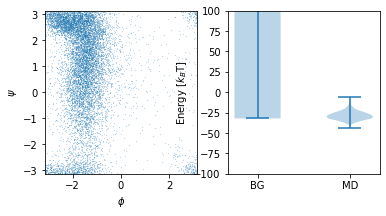

In [27]:
n_samples = 10000
samples = generator.sample(n_samples)

fig, axes = plt.subplots(1, 2, figsize=(6,3))

plot_phi_psi(axes[0], samples)
plot_energies(axes[1], samples)

del samples

### Mixed Training

The next step is "mixed" training with a combination of NLL and KLL. To retain some of the progress made in the NLL phase, we decrease the learning rate and increase the batch size.

In [28]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = nn.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True
)

Mixed training will be considerably slower. 
To speed it up, you can change the settings for the OpenMM energy when creating the energy model. For example, consider not passing `n_workers=1`.

In [29]:
mixed_trainer.train(
    n_iter=1000, 
    data=training_data,
    batchsize=1000,
    n_print=50, 
    w_energy=0.1,
    w_likelihood=0.9
)

1	NLL: -228.6567	KLL: 602.2184	
51	NLL: -232.9775	KLL: 566.2542	
101	NLL: -234.1960	KLL: 548.7974	
151	NLL: -234.9788	KLL: 518.2621	
201	NLL: -235.5245	KLL: 498.7918	
251	NLL: -236.6823	KLL: 487.5763	
301	NLL: -237.2464	KLL: 468.2600	
351	NLL: -237.2711	KLL: 464.3633	
401	NLL: -238.0485	KLL: 457.3008	
451	NLL: -238.5704	KLL: 458.7647	
501	NLL: -239.2854	KLL: 449.6733	
551	NLL: -239.6127	KLL: 446.1324	
601	NLL: -240.4533	KLL: 444.6346	
651	NLL: -239.8679	KLL: 444.0461	
701	NLL: -241.2173	KLL: 442.2700	
751	NLL: -241.4852	KLL: 445.4462	
801	NLL: -242.3161	KLL: 443.7641	
851	NLL: -242.8688	KLL: 432.8256	
901	NLL: -242.8045	KLL: 441.1501	
951	NLL: -243.4812	KLL: 439.3494	


Plot the results:

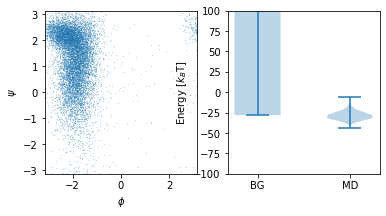

In [30]:
n_samples = 10000
samples = generator.sample(n_samples)
    
fig, axes = plt.subplots(1, 2, figsize=(6,3))

trajectory = plot_phi_psi(axes[0], samples)
plot_energies(axes[1], samples)

del samples

With nglview installed, we can also take a look at the samples.

In [31]:
try:
    import nglview as nv
    widget = nv.show_mdtraj(trajectory)
except:
    widget = None
widget

_ColormakerRegistry()

NGLWidget(max_frame=9999)

## Conclusions

This tutorial has introduced the most basic concepts and implementations underlying Boltzmann generators and `bgtorch`. That said, the trained networks did not to a particularly good job in reproducing the molecular Boltzmann distribution. Specifically, they only modeled the major modes of the $\phi$ angle and still produced many samples with unreasonably large energies. Let's look at a few shortcomings of the present architecture:

### 1) Unconstrained Internal Coordinates
Bonds, angles, and torsions cannot take arbitrary values in practice. Bond lengths need to be positive, angles live in $[0,\pi],$ and torsions are periodic in $[-\pi, \pi].$ Neither those bounds nor the periodicity of torsions distributions have been taken into account by the present Boltzmann generator. The layers of the normalizing flow should be build in a way that preserves these constraints on the ICs.

### 2)  Random Coupling
The input was split into two channels randomly, which amounts to random conditioning of ICs on one another. A partial remedy is to define the conditioning in a physically informed manner. Another solution is to augment the base space by momenta, which can be done augmented normalizing flows (see for instance the notebook on temperature-steering flows).

### 3) RealNVP Layers
Affine coupling layers are well-known to perform poorly on mode separation so that the metastable region around $\phi \approx \pi/2$ was not captured by the generator. Other architectures such as augmented flows or neural spline flows do a better job.

### 4) Training
The generators were only trained for relatively few iterations and performance may improve with longer training and better choices of the learning rate and hyperparameters.